# Causal Methods on UNSW-NB15 dataset

**IMPORTANT NOTE: Methods in the notebook assumes the following properties**
1. Linearity
2. Non-Gaussian continuous distribution
3. Acyclicity
4. No hidden common causes

In [1]:
import lingam
from lingam.utils import make_dot

from dowhy import CausalModel

#import pyarrow.parquet as pa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest, anderson
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

# Set Seed for Reproducability

In [2]:
SEED = 432432
np.random.seed(SEED)

# Dataset
from: https://www.kaggle.com/datasets/dhoogla/unswnb15

from: https://www.kaggle.com/datasets/mrwellsdavid/unsw-nb15

In [3]:
df_training = pd.read_csv('data/UNSW-NB15/UNSW_NB15_training-set.csv')
df_testing = pd.read_csv('data/UNSW-NB15/UNSW_NB15_testing-set.csv')

In [4]:
df_training.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [5]:
df_testing.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [6]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [7]:
df_training['attack_cat'].value_counts()

attack_cat
Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: count, dtype: int64

In [8]:
df_training['label'].value_counts()

label
1    45332
0    37000
Name: count, dtype: int64

## Training Dataset

In [9]:
#selected_columns = ['tcprtt', 'synack', 'ackdat', 'spkts', 'dpkts', 'sinpkt', 'dinpkt', 'label']
#selected_columns = ['ct_dst_sport_ltm', 'sloss', 'dloss', 'sload', 'dload', 'label']


#selected_columns = ['sttl', 'ct_state_ttl', 'ct_dst_sport_ltm', 'swin', 'dload', 'dwin', 'rate', 'attack_cat', 'label']
#selected_columns = ['sbytes', 'sload', 'ct_state_ttl', 'dbytes', 'sttl', 'smean', 'dttl', 'rate', 'dur', 'dmean', 'dinpkt', 'dload', 'dpkts', 'sinpkt', 'synack', 'attack_cat', 'label']
#selected_columns = ['sbytes', 'sload', 'synack', 'attack_cat', 'label']


#df_train_selected = df_training[selected_columns].copy()
#df_train_selected['label'] = df_train_selected['label'].apply(lambda x: float(x))
#df_train_selected['attack_cat'] = df_train_selected['attack_cat'].astype('category').cat.codes


#df_train_selected = df_train_selected[df_train_selected['label'] == 0]
#df_train_selected = df_train_selected[(df_train_selected['attack_cat'] == 0) | (df_train_selected['attack_cat'] == 2)]


selected_cols = list(df_training.select_dtypes(include=['int', 'float']).columns)
#df_train_selected = df_training[selected_cols+['label', 'attack_cat']].copy()
df_train_selected = df_training[selected_cols+['attack_cat']].copy()
df_train_selected['attack_cat'] = df_train_selected['attack_cat'].astype('category').cat.codes


df_train_selected.head()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,attack_cat
0,1,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,...,1,2,0,0,0,1,2,0,0,6
1,2,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,...,1,2,0,0,0,1,2,0,0,6
2,3,0.000005,2,0,1068,0,200000.0051,254,0,854400000.0,...,1,3,0,0,0,1,3,0,0,6
3,4,0.000006,2,0,900,0,166666.6608,254,0,600000000.0,...,1,3,0,0,0,2,3,0,0,6
4,5,0.000010,2,0,2126,0,100000.0025,254,0,850400000.0,...,1,3,0,0,0,2,3,0,0,6


# Causal Discovery

In [10]:
model_discovery = lingam.DirectLiNGAM()

model_discovery.fit(df_train_selected)

In [11]:
model_discovery.causal_order_

[np.int64(27),
 np.int64(34),
 np.int64(35),
 np.int64(4),
 np.int64(10),
 np.int64(5),
 np.int64(32),
 np.int64(31),
 np.int64(36),
 np.int64(15),
 np.int64(14),
 np.int64(13),
 np.int64(39),
 np.int64(26),
 np.int64(8),
 np.int64(22),
 np.int64(21),
 np.int64(23),
 np.int64(19),
 np.int64(18),
 np.int64(20),
 np.int64(17),
 np.int64(12),
 np.int64(29),
 np.int64(3),
 np.int64(11),
 np.int64(30),
 np.int64(37),
 np.int64(33),
 np.int64(38),
 np.int64(28),
 np.int64(0),
 np.int64(40),
 np.int64(41),
 np.int64(6),
 np.int64(9),
 np.int64(24),
 np.int64(2),
 np.int64(25),
 np.int64(16),
 np.int64(1),
 np.int64(7)]

In [12]:
model_discovery.adjacency_matrix_

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.26828714e+04,  0.00000000e+00,  0.00000000e+00],
       [-1.43458671e-05,  0.00000000e+00,  4.45409975e-02, ...,
        -1.36163979e+01, -4.35188776e-01, -1.26530199e-01],
       [-9.44758805e-06,  0.00000000e+00,  0.00000000e+00, ...,
        -2.92453723e+00,  0.00000000e+00, -3.70135221e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.37935734e-06,  0.00000000e+00,  0.00000000e+00, ...,
        -1.94158154e-01,  0.00000000e+00,  0.00000000e+00],
       [ 7.57362059e-06,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16201427e-01, -1.84589911e+00,  0.00000000e+00]],
      shape=(42, 42))

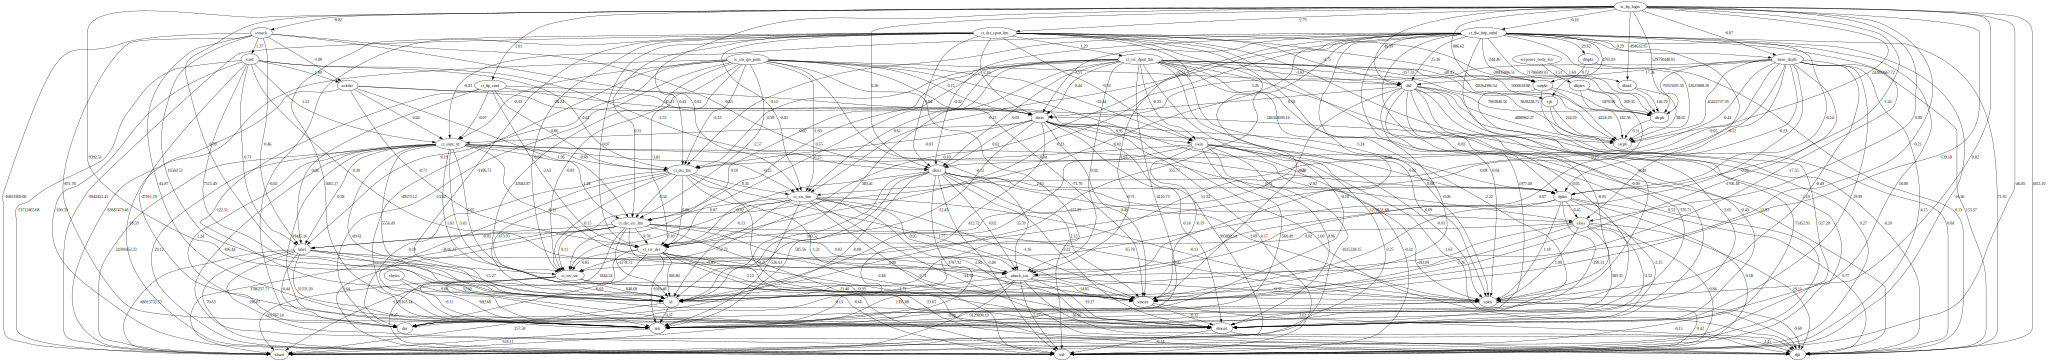

In [13]:
causal_graph = make_dot(model_discovery.adjacency_matrix_, labels=list(df_train_selected.columns), lower_limit=0.02)
causal_graph

In [14]:
if os.path.exists('CD_AllNumerical.gv'):
    os.remove('CD_AllNumerical.gv')
    print('removed previously saved graph')

#causal_graph.save('CD_AllNumerical.gv') # SAVE IN DOT FORMAT
causal_graph.view('CD_AllNumerical.gv') # ALSO GENERATES A PDF FILE

removed previously saved graph


'CD_AllNumerical.gv.pdf'

# Evaluate Causal Discovery

In [15]:
lingam.utils.evaluate_model_fit(model_discovery.adjacency_matrix_, df_train_selected)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,864,864,4.642382e+06,0.0,8.015353e+06,0.420859,0.420814,0.420814,0.420814,0.420859,0.255442,-34.772249,328.649841,56.386124


In [16]:
#lingam.utils.evaluate_model_fit(model_discovery.adjacency_matrix_, df_testing_selected)

# List Adjacency

In [17]:
model_discovery.adjacency_matrix_.shape

In [18]:
model_discovery.adjacency_matrix_[:, 1] == model_discovery.adjacency_matrix_[1, :]

array([False,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
        True,  True, False,  True,  True,  True, False, False,  True,
        True,  True, False, False, False, False,  True,  True,  True,
       False,  True, False, False, False, False])

In [19]:
df_train_selected.columns

Index(['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit',
       'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat',
       'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label', 'attack_cat'],
      dtype='object')

In [34]:
#SELECT_COLUMN = 'label'
SELECT_COLUMN = 'attack_cat'
#SELECT_COLUMN = 'synack'
#SELECT_COLUMN = 'sload'

SELECTED_COLUMN_IDX = df_train_selected.columns.get_loc(SELECT_COLUMN)
MIN_ADJ_VALUE = 0.01

adj_dict = {df_train_selected.columns[adj_idx]: float(adj_value) for adj_idx, adj_value in enumerate(model_discovery.adjacency_matrix_[SELECTED_COLUMN_IDX, :])}
sorted_adj_dict = {k: v for k, v in sorted(adj_dict.items(), key=lambda x: abs(x[1]), reverse=True)}

for k, v in sorted_adj_dict.items():
    if abs(v) < MIN_ADJ_VALUE:
        continue
    print(f'{k:<20} {v:10.4f}')

label                   -1.8459
tcprtt                   0.2959
is_ftp_login            -0.2097
ct_state_ttl            -0.1175
is_sm_ips_ports         -0.1162
ct_src_ltm              -0.0527
ct_src_dport_ltm         0.0436
ct_flw_http_mthd        -0.0418
trans_depth             -0.0401
ct_dst_sport_ltm         0.0256
dloss                   -0.0235
ct_dst_src_ltm           0.0230
ct_dst_ltm               0.0162
ct_srv_dst              -0.0152


# Draw the result of LiNGAM with prediction model

In [21]:
from sklearn.linear_model import LinearRegression

target = df_train_selected.columns.get_loc('label')
features = [i for i in range(df_train_selected.shape[1]) if i != target]

features.remove(df_train_selected.columns.get_loc('attack_cat')) # ALSO REMOVE ATTACK CATEGORY TO AVIOD CHEATING!

reg = LinearRegression()
reg.fit(df_train_selected.iloc[:, features], df_train_selected.iloc[:, target])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [22]:
causal_graph_with_prediction_model = make_dot(
    model_discovery.adjacency_matrix_, 
    prediction_feature_indices=features, 
    prediction_coefs=reg.coef_,
    #prediction_coefs=reg.feature_importances_,
    labels=list(df_train_selected.columns), 
    lower_limit=0.02,
)

#causal_graph_with_prediction_model.save('CD_AllNumerical_PredictionModel.gv') # SAVE IN DOT FORMAT
causal_graph_with_prediction_model.view('CD_AllNumerical_PredictionModel.gv') # ALSO GENERATES A PDF FILE

if os.path.exists('CD_AllNumerical_PredictionModel.gv'):
    os.remove('CD_AllNumerical_PredictionModel.gv')
    print('removed previously saved graph')

removed previously saved graph


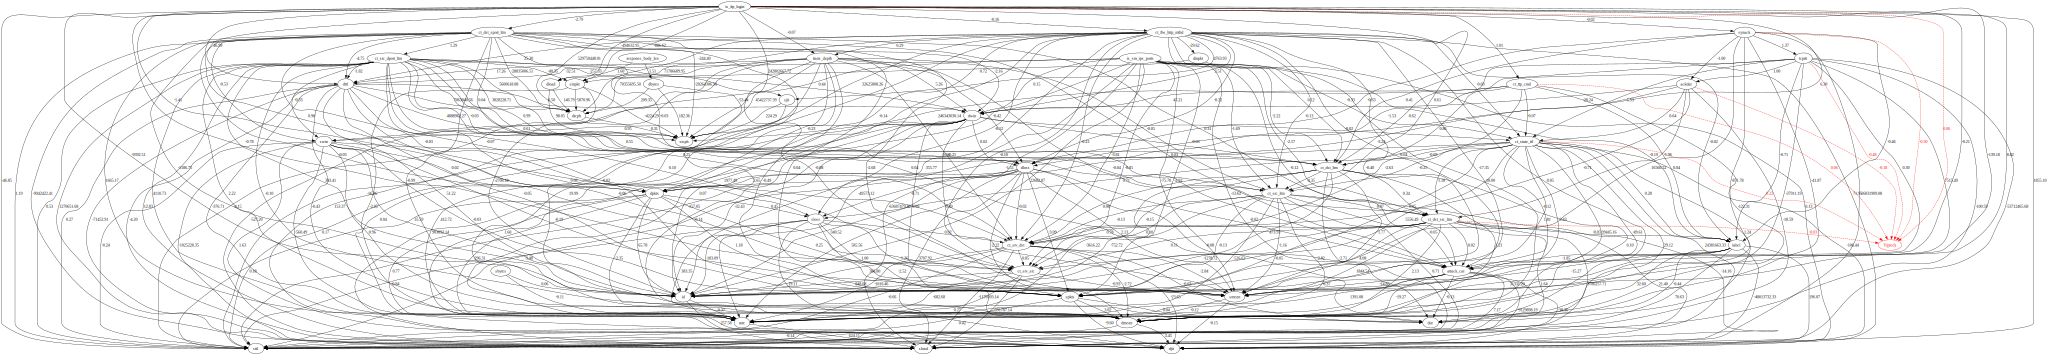

In [23]:
causal_graph_with_prediction_model

# Causal Infernece

In [24]:
with open('CD_AllNumerical.gv') as dot_f:
    causal_graph_text_dot_format = dot_f.read()

#print(causal_graph_text_dot_format)

In [25]:
model_inference = CausalModel(
    data=df_train_selected,
    #treatment='synack',
    treatment='synack',
    #outcome='label',
    outcome='attack_cat',
    graph=causal_graph_text_dot_format, # USE THE DISCOVERED GRAPH AS INITIAL ASSUMPTION
)

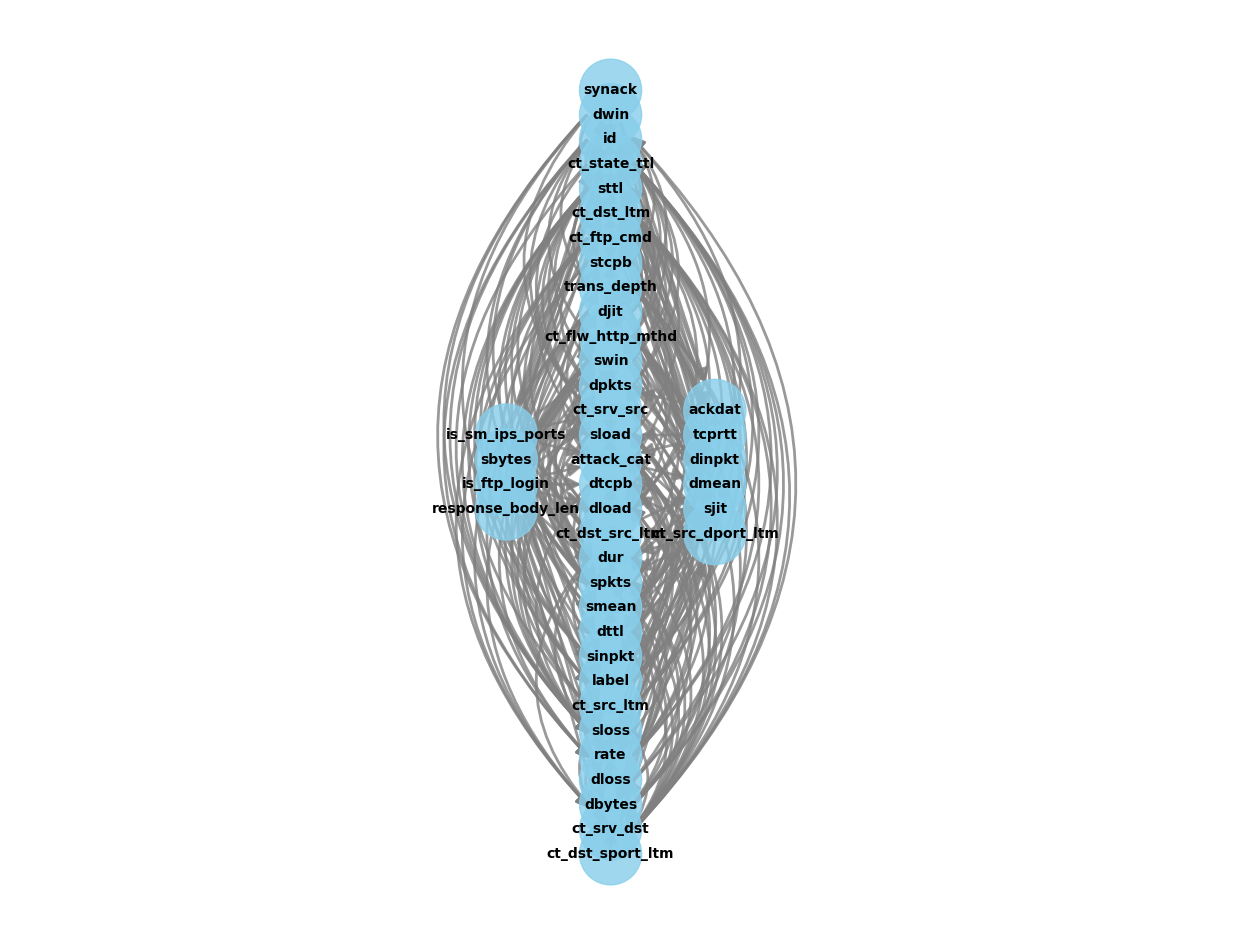

In [26]:
model_inference.view_model(size=(16, 12), file_name='CD_AllNumerical_InferenceModel')

# Identify the Effect

In [27]:
identified_estimand = model_inference.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                
─────────(E[attack_cat|is_ftp_login])
d[synack]                            
Estimand assumption 1, Unconfoundedness: If U→{synack} and U→attack_cat then P(attack_cat|synack,is_ftp_login,U) = P(attack_cat|synack,is_ftp_login)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
    d                                
─────────(E[attack_cat|is_ftp_login])
d[synack]                            
Estimand assumption 1, Unconfoundedness: If U→{synack} and U→attack_cat then P(attack_cat|synack,is_ftp_login,U) = P(attack_cat|synack,is_ftp_login)



# Estimate Effect

In [28]:
estimate = model_inference.estimate_effect(
    identified_estimand,
    method_name='backdoor.linear_regression'
)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                
─────────(E[attack_cat|is_ftp_login])
d[synack]                            
Estimand assumption 1, Unconfoundedness: If U→{synack} and U→attack_cat then P(attack_cat|synack,is_ftp_login,U) = P(attack_cat|synack,is_ftp_login)

## Realized estimand
b: attack_cat~synack+is_ftp_login+synack*dttl+synack*ct_dst_sport_ltm+synack*is_sm_ips_ports+synack*ct_flw_http_mthd+synack*trans_depth+synack*ct_ftp_cmd+synack*ct_src_dport_ltm
Target units: 

## Estimate
Mean value: 449.6016323647266
### Conditional Estimates
__categorical__dttl  __categorical__ct_dst_sport_ltm  __categorical__is_sm_ips_ports  __categorical__ct_flw_http_mthd  __categorical__trans_depth  __categorical__ct_ftp_cmd  __categorical__ct_src_dport_ltm
(-0.001, 29.0]       (0.999, 4.0]                     (-0.001, 1.0]                   (-0.

# Refute

## Random Common Cause Variable

In [29]:
refute = model_inference.refute_estimate(
    identified_estimand, 
    estimate,
    method_name='random_common_cause'
)

print(f'Estimated average treatment effect (ATE): {estimate.value}')
print()

print('Refute:')
print(refute)

Estimated average treatment effect (ATE): 449.6016323647266

Refute:
Refute: Add a random common cause
Estimated effect:449.6016323647266
New effect:449.5956789681082
p value:0.9



## Unobserved Common Cause Variable


In [30]:
refute = model_inference.refute_estimate(
    identified_estimand, 
    estimate,
    method_name='add_unobserved_common_cause',
    confounders_effect_on_treatment='linear', 
    confounders_effect_on_outcome='linear',
    effect_strength_on_treatment=0.01, 
    effect_strength_on_outcome=0.0
)

print(f'Estimated average treatment effect (ATE): {estimate.value}')
print()

print('Refute:')
print(refute)

Estimated average treatment effect (ATE): 449.6016323647266

Refute:
Refute: Add an Unobserved Common Cause
Estimated effect:449.6016323647266
New effect:1.3174360552046824



##  Replacing Treatment with a Random (Placebo) Variable

In [31]:
refute = model_inference.refute_estimate(
    identified_estimand, 
    estimate,
    method_name='placebo_treatment_refuter', 
    placebo_type='permute',
    num_simulations=100 # (at least 100)
)

print(f'Estimated average treatment effect (ATE): {estimate.value}')
print()

print('Refute:')
print(refute)

Estimated average treatment effect (ATE): 449.6016323647266

Refute:
Refute: Use a Placebo Treatment
Estimated effect:449.6016323647266
New effect:0.019291416706268213
p value:0.78



## Removing a Random Subset of the Data

In [32]:
refute = model_inference.refute_estimate(
    identified_estimand, 
    estimate,
    method_name='data_subset_refuter', 
    subset_fraction=0.8,
    num_simulations=100
)

print(f'Estimated average treatment effect (ATE): {estimate.value}')
print()

print('Refute:')
print(refute)

Estimated average treatment effect (ATE): 449.6016323647266

Refute:
Refute: Use a subset of data
Estimated effect:449.6016323647266
New effect:540.9536385090324
p value:0.56

